### 라이브러리, 데이터셋 호출

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from tableone import TableOne
from sklearn.manifold import TSNE
import umap
import matplotlib.font_manager as fm
from IPython.core.display import display, HTML

# 한글 폰트 설정 (맑은 고딕)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_14636\822133913.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [3]:
df=pd.read_csv('../real_data/공시지가_전처리.csv')

### 1. tableOne
* TableOne을 통해 주요 변수들의 분포와 특성을 간략히 확인하고, 데이터의 기초 통계 구조를 파악

In [ ]:
# object 타입인 컬럼들만 골라서 범주형 변수로 지정
categorical = df.select_dtypes(include='object').columns.tolist()
nonnormal=['공시지가','면적'] # 연속형 변수 지정
# TableOne 생성
table1 = TableOne(df, categorical=categorical, nonnormal=nonnormal, groupby=None)
# DataFrame으로 변환 후 저장
table1_df = table1.tableone.reset_index()
# 멀티 인덱스를 단일 문자열로 변환하여, 가독성 향상 
table1_df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in table1_df.columns]
# 저장
table1_df.to_excel("../real_data/table1_result.xlsx", index=False)

display(HTML(table1.to_html()))


C:\Users\jeongbin\AppData\Local\Temp\ipykernel_27480\1374664176.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


groupby 적용한 테이블원

In [7]:
# 공시지가를 기준으로 4분위 그룹 만들기
df['공시지가_4분위'] = pd.qcut(df['내년_공시지가'], 4, labels=['1Q', '2Q', '3Q', '4Q'])

table2 = TableOne(df, categorical=categorical, nonnormal=nonnormal, groupby='공시지가_4분위')

# DataFrame으로 변환 후 저장
table2_df = table2.tableone.reset_index()
# 멀티 인덱스 처리
table2_df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in table2_df.columns]
# 저장
table2_df.to_excel("../real_data/table2_result.xlsx", index=False)

display(HTML(table2.to_html()))

c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\tableone\preprocessors.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupbylvls = sorted(data.groupby(groupby).groups.keys())  # type: ignore
c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\tableone\tables.py:399: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_cont = pd.pivot_table(cont_data, columns=[groupby], aggfunc=aggfuncs)
c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\tableone\tables.py:399: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pa

### 1-2. t-map

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
# 범주형 변수 리스트
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# 인코더 생성
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# train 데이터 fit_transform
df_encoded = encoder.fit_transform(df[categorical_cols])

# 연속형 변수 정규화: '면적'
scaler = MinMaxScaler()
area_scaled = scaler.fit_transform(df[['면적']])  # 2D 유지

# 인코딩된 데이터와 면적 정규화 결합
df_final = np.hstack([df_encoded, area_scaled])

In [ ]:

# 1. 분위수 생성 (공시지가 기준)
quartiles = ['1Q', '2Q', '3Q', '4Q']
df['공시지가_4분위'] = pd.qcut(df['내년_공시지가'], 4, labels=quartiles)

# 2. 각 분위수에서 5,000개씩 균등 샘플링
df_sample = df.groupby('공시지가_4분위', group_keys=False).apply(
    lambda x: x.sample(5000, random_state=42)
).copy()
# 3. X_sample 생성 
X_sample = df_final[df_sample.index] 

# 4. t-SNE 적용 2차원
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(X_sample)

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_27480\1382870589.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample = df.groupby('공시지가_4분위', group_keys=False).apply(
C:\Users\jeongbin\AppData\Local\Temp\ipykernel_27480\1382870589.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('공시지가_4분위', group_keys=False).apply(


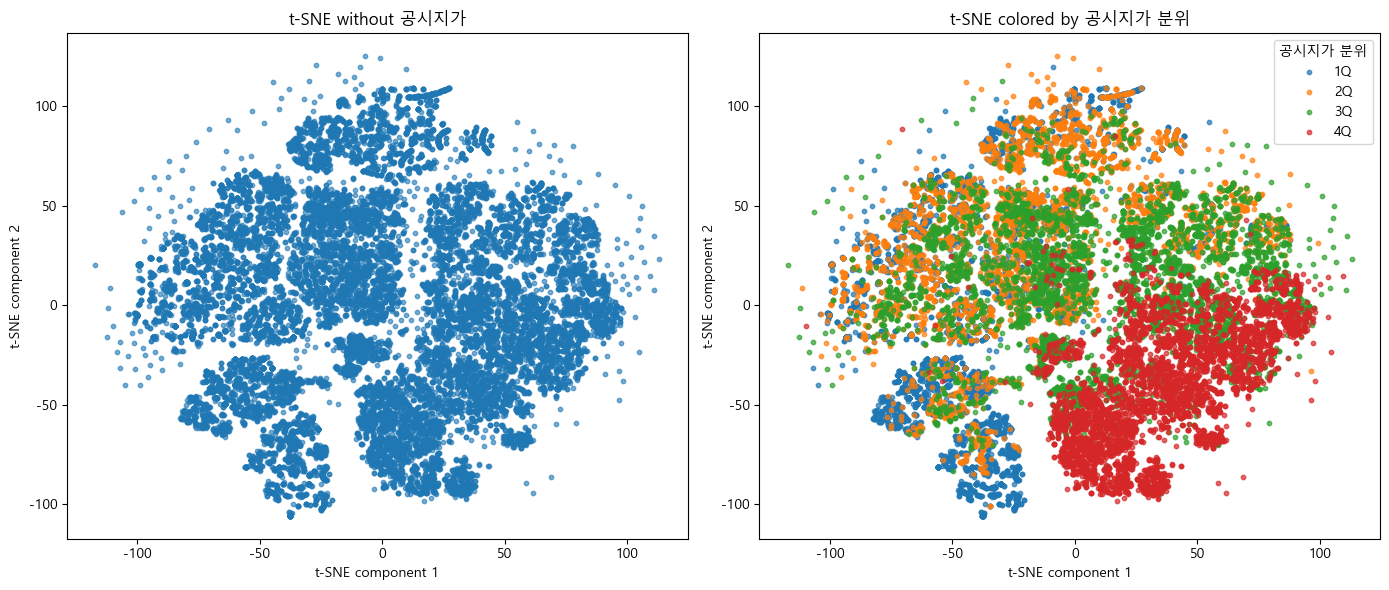

In [ ]:
# 인덱스 리셋 -> 매칭 오류 제거 
df_sample = df_sample.reset_index(drop=True)

# t-SNE 시각화 서브플롯
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 왼쪽: 공시지가 없이 시각화
axes[0].scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, alpha=0.6)
axes[0].set_title('t-SNE without 공시지가')
axes[0].set_xlabel('t-SNE component 1')
axes[0].set_ylabel('t-SNE component 2')

# 오른쪽: 공시지가 분위수 색상
# 각 분위(label)에 해당하는 인덱스를 이용해 색상 구분 
for label in quartiles:
    idx = df_sample[df_sample['공시지가_4분위'] == label].index.to_numpy()  # 이제 idx는 0~19999 범위
    axes[1].scatter(df_tsne[idx, 0], df_tsne[idx, 1], s=10, alpha=0.7, label=label)

axes[1].set_title('t-SNE colored by 공시지가 분위')
axes[1].set_xlabel('t-SNE component 1')
axes[1].set_ylabel('t-SNE component 2')
axes[1].legend(title='공시지가 분위')

plt.tight_layout()
plt.show()


### 1-3. UMAP

In [ ]:
# 1. 각 분위수에서 25,000개씩 균등 샘플링 (총 100,000개)
df_sample = df.groupby('공시지가_4분위', group_keys=False).apply(
    lambda x: x.sample(25000, random_state=42)
).copy()
X_sample = df_final[df_sample.index]  

# 2. UMAP 수행 -> 고려할 점 개수 15개, 최소 거리 0.1
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
df_umap = umap_model.fit_transform(X_sample)  # shape: (100000, 2)

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_27480\639482403.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample = df.groupby('공시지가_4분위', group_keys=False).apply(
C:\Users\jeongbin\AppData\Local\Temp\ipykernel_27480\639482403.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('공시지가_4분위', group_keys=False).apply(
c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_

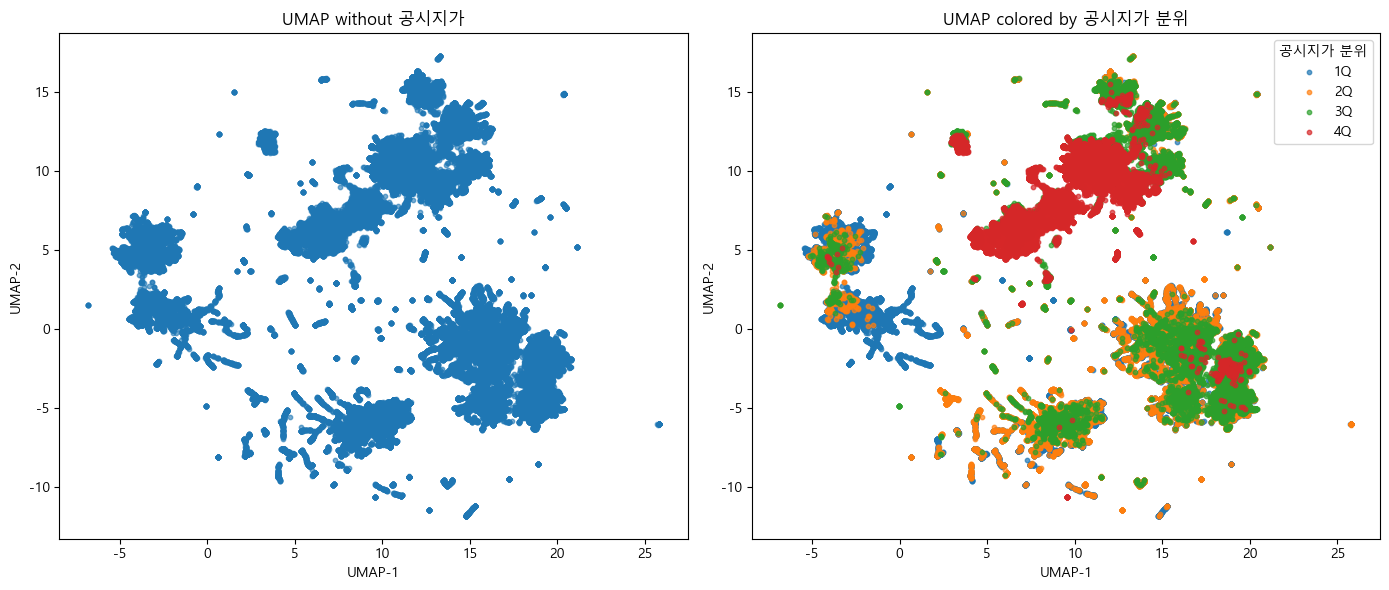

In [ ]:
# 인덱스 리셋
df_sample = df_sample.reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 왼쪽: 공시지가 없는 UMAP 결과
axes[0].scatter(df_umap[:, 0], df_umap[:, 1], s=10, alpha=0.6)
axes[0].set_title('UMAP without 공시지가')
axes[0].set_xlabel('UMAP-1')
axes[0].set_ylabel('UMAP-2')

# 오른쪽: 공시지가 4분위로 색상지정한 UMAP 결과 
for label in quartiles:
    idx = df_sample[df_sample['공시지가_4분위'] == label].index.to_numpy()
    axes[1].scatter(df_umap[idx, 0], df_umap[idx, 1], s=10, alpha=0.7, label=label)

axes[1].set_title('UMAP colored by 공시지가 분위')
axes[1].set_xlabel('UMAP-1')
axes[1].set_ylabel('UMAP-2')
axes[1].legend(title='공시지가 분위')

plt.tight_layout()
plt.show()

### 2-1. CCA

In [34]:
from sklearn.cross_decomposition import CCA
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

In [31]:
# 인코딩된 변수명 가져오기
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# 면적 컬럼 추가해서 전체 컬럼 리스트 구성
final_columns = list(encoded_feature_names) + ['면적']

# numpy 배열 → DataFrame 변환
df_final = pd.DataFrame(df_final, columns=final_columns)

#### 단변량

In [ ]:
# 공시지가 정규화
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(df[['내년_공시지가']])

# 결과 저장 리스트
results = []

# 각 변수별로 CCA 수행
for col in df_final.columns:
    X1 = df_final[[col]].values  # (n, 1)
    X2 = y_scaled  # (n, 1)

    cca = CCA(n_components=1, scale=False)
    X1_c, X2_c = cca.fit(X1, X2).transform(X1, X2)

    r = np.corrcoef(X1_c[:, 0], X2_c[:, 0])[0, 1]
    p = linregress(X1_c[:, 0], X2_c[:, 0]).pvalue

    results.append({'변수명': col, '정준상관계수(r)': r, 'p-value': p})

# 결과 정리
cca_results = pd.DataFrame(results)
cca_results = cca_results.sort_values(by='정준상관계수(r)', key=np.abs, ascending=False).reset_index(drop=True)

# 상위 10개 확인
print(cca_results.head(10))


             변수명  정준상관계수(r)  p-value
0      시도명_서울특별시   0.598557      0.0
1       이용상황_상업용   0.413496      0.0
2      주위환경_상업지대   0.397727      0.0
3           지목_대   0.333889      0.0
4   용도지역1_일반상업지역   0.307336      0.0
5   주위환경_농촌·경작지대   0.304101      0.0
6      용도지구_방화지구   0.241765      0.0
7  기타제한_지구단위계획구역   0.234257      0.0
8        형상명_부정형   0.216560      0.0
9      도로교통_광대소각   0.212036      0.0


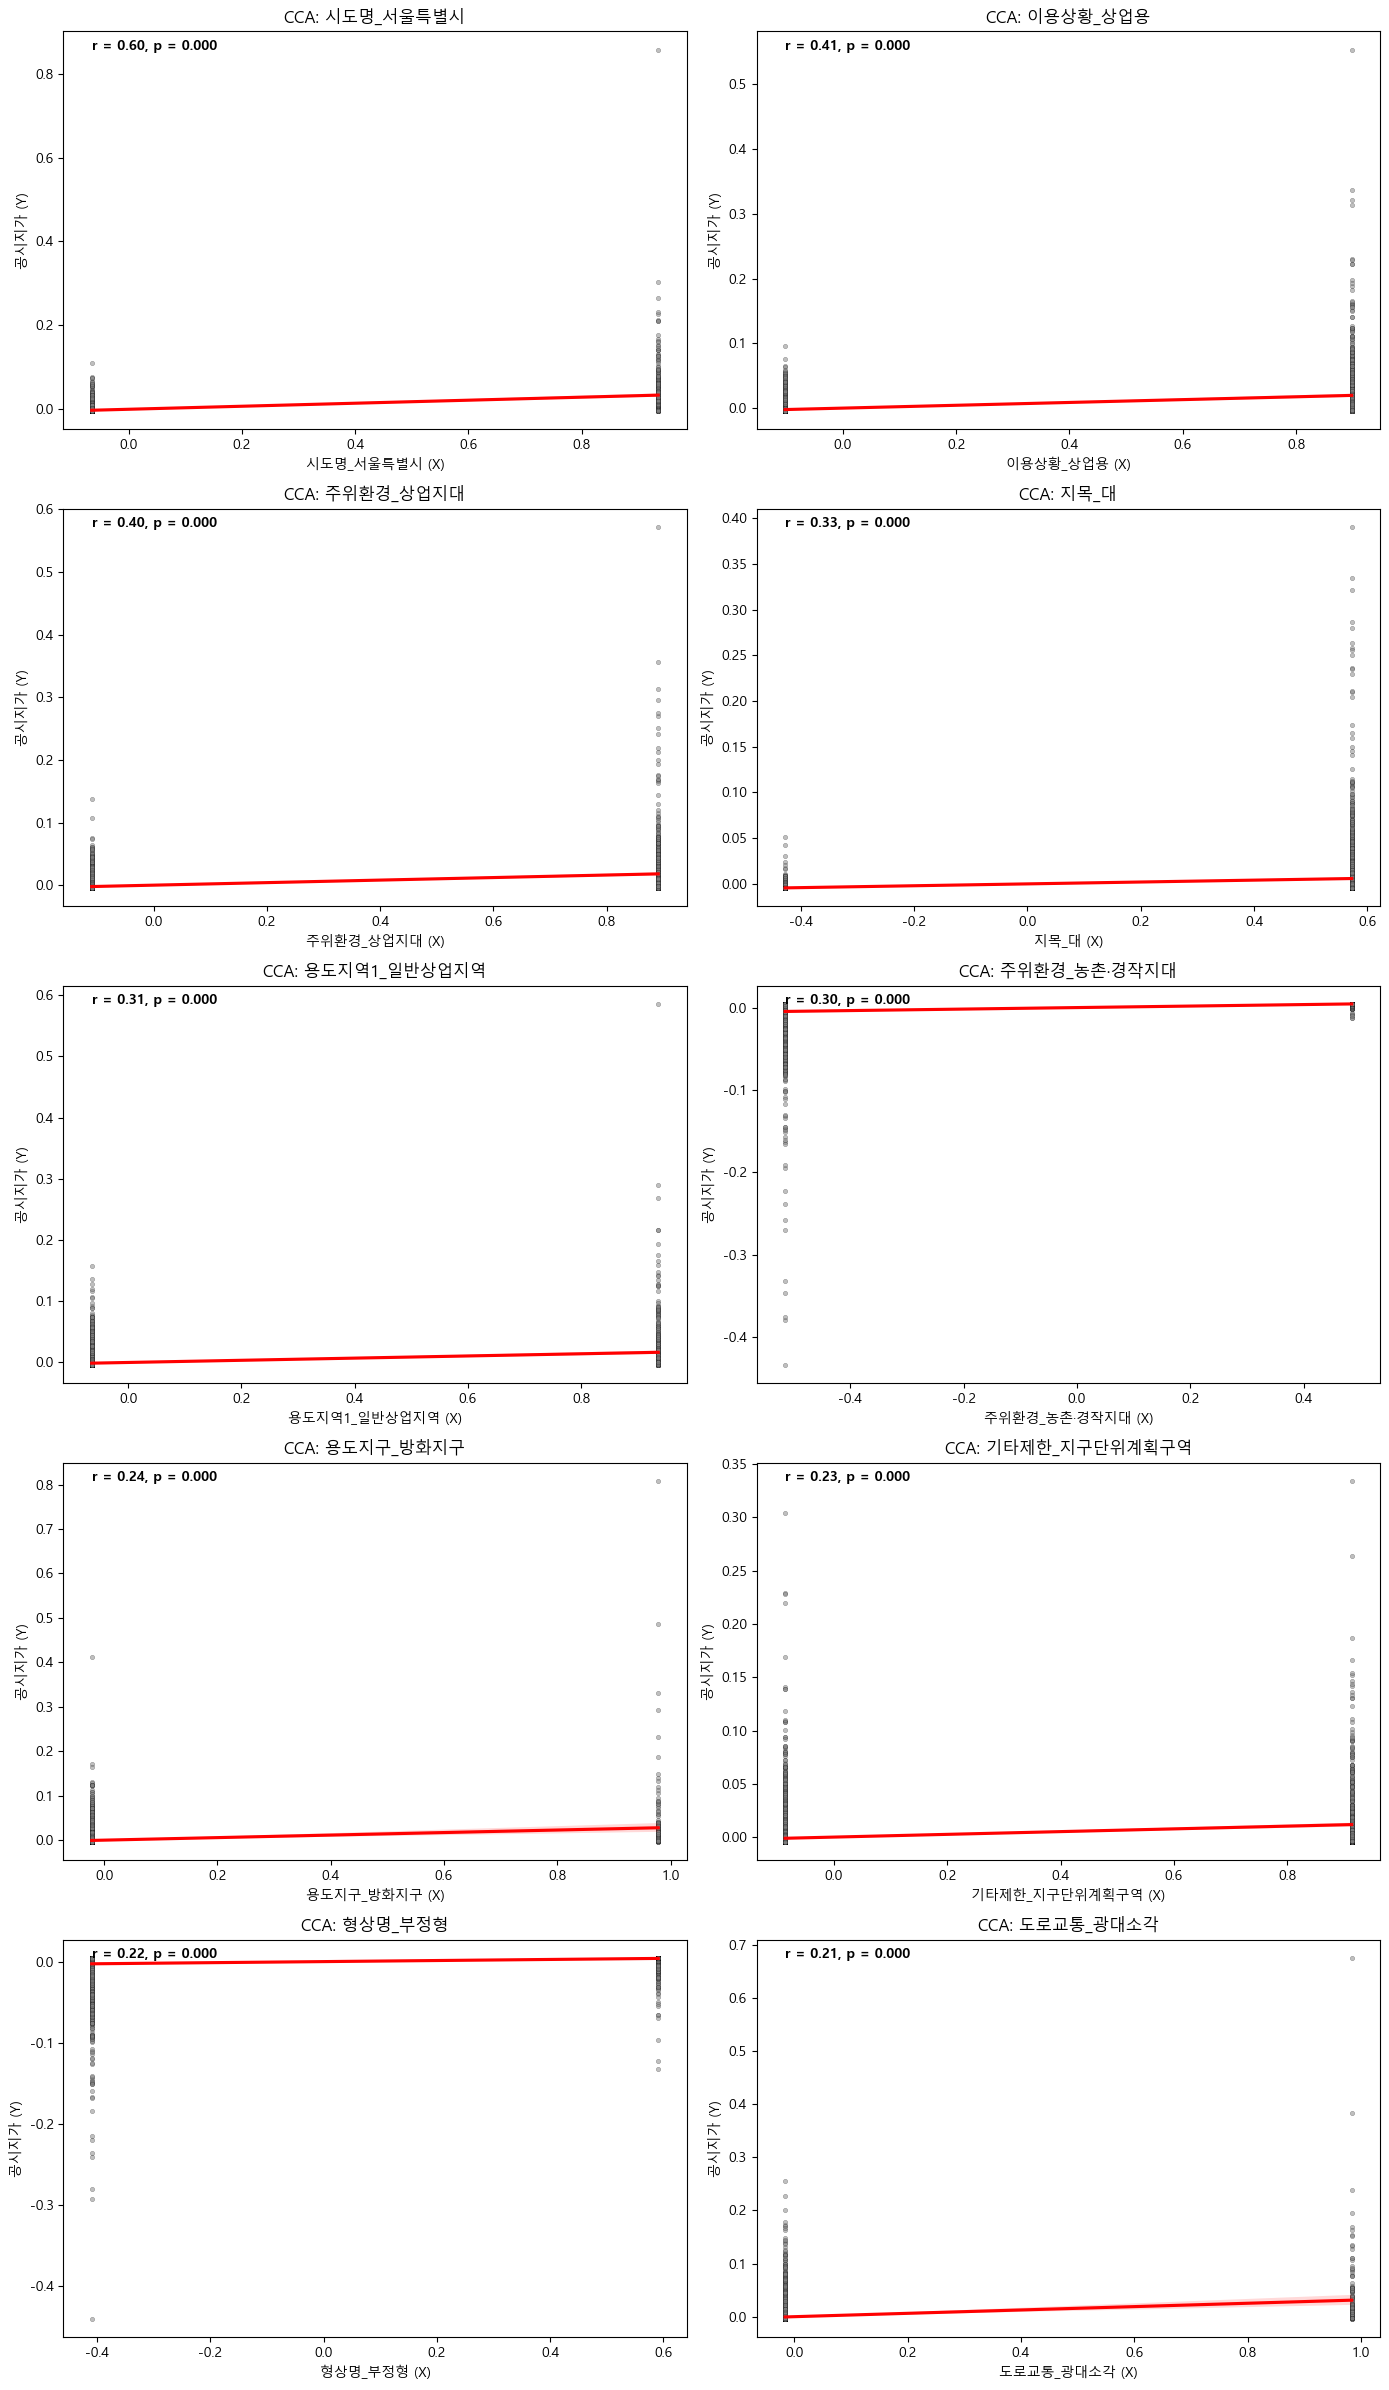

In [ ]:
# 상위 10개 변수 선택
top_10 = cca_results.head(10)

# 서브플롯 설정
fig, axes = plt.subplots(5, 2, figsize=(14, 24))
axes = axes.flatten()

for i, row in enumerate(top_10.itertuples()):
    col = row.변수명  
    X1 = df_final[[col]].values
    X2 = y_scaled # 공지지가 값 

    cca = CCA(n_components=1, scale=False)
    X1_c, X2_c = cca.fit(X1, X2).transform(X1, X2)

    r = np.corrcoef(X1_c[:, 0], X2_c[:, 0])[0, 1] # 상관계수
    p = linregress(X1_c[:, 0], X2_c[:, 0]).pvalue # p값 

    ax = axes[i]

    # 전체 중 10,000개 샘플링
    if len(X1_c) > 10000:
        idx = np.random.choice(len(X1_c), 10000, replace=False)
    else:
        idx = np.arange(len(X1_c))
    # 산점도 회귀선 그리기 
    sns.scatterplot(x=X1_c[idx, 0], y=X2_c[idx, 0], color='grey', edgecolor='k', s=10, alpha=0.5, ax=ax)
    sns.regplot(x=X1_c[idx, 0], y=X2_c[idx, 0], scatter=False, color='red', ax=ax)
    # 그래프 내에, r,p-value text 추가
    ax.text(min(X1_c[idx, 0]), max(X2_c[idx, 0]), f'r = {r:.2f}, p = {p:.3f}',
            horizontalalignment='left', size='medium', color='black', weight='semibold')

    ax.set_xlabel(f'{col} (X)')
    ax.set_ylabel('공시지가 (Y)')
    ax.set_title(f'CCA: {col}')

plt.tight_layout()
plt.show()


#### 다변량

In [ ]:
from collections import defaultdict

# 2. 기존 변수명 기준으로 그룹화
grouped_features = defaultdict(list)

for col in df_final.columns:
    base = col.split('_')[0]  # 예: '지목_대' → '지목' '_'기준으로 분할 
    grouped_features[base].append(col) # '지목'을 키로 리스트로 추가 

# 3. 그룹 단위 CCA 수행
results = []

for base_var, cols in grouped_features.items():

    X = df_final[cols].values
    Y = y_scaled

    cca = CCA(n_components=1, scale=False)
    X_c, Y_c = cca.fit(X, Y).transform(X, Y)

    r = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
    p = linregress(X_c[:, 0], Y_c[:, 0]).pvalue

    results.append({'기존 변수명': base_var, '정준상관계수(r)': r, 'p-value': p})

# 4. 정리된 결과
grouped_cca_results = pd.DataFrame(results).sort_values(by='정준상관계수(r)', key=np.abs, ascending=False).reset_index(drop=True)
print(grouped_cca_results)

       기존 변수명  정준상관계수(r)        p-value
0         시도명   0.623641   0.000000e+00
1       용도지역1   0.474303   0.000000e+00
2        주위환경   0.467864   0.000000e+00
3        이용상황   0.466631   0.000000e+00
4        도로교통   0.385252   0.000000e+00
5          지목   0.335851   0.000000e+00
6        기타제한   0.310369   0.000000e+00
7        용도지구   0.280220   0.000000e+00
8         형상명   0.263982   0.000000e+00
9         지세명   0.186669   0.000000e+00
10       임야구분   0.116427   0.000000e+00
11       농지구분   0.106879   0.000000e+00
12       지번구분   0.106535   0.000000e+00
13  계획시설 저촉여부   0.049676  3.011082e-252
14         면적   0.041473  2.183038e-176


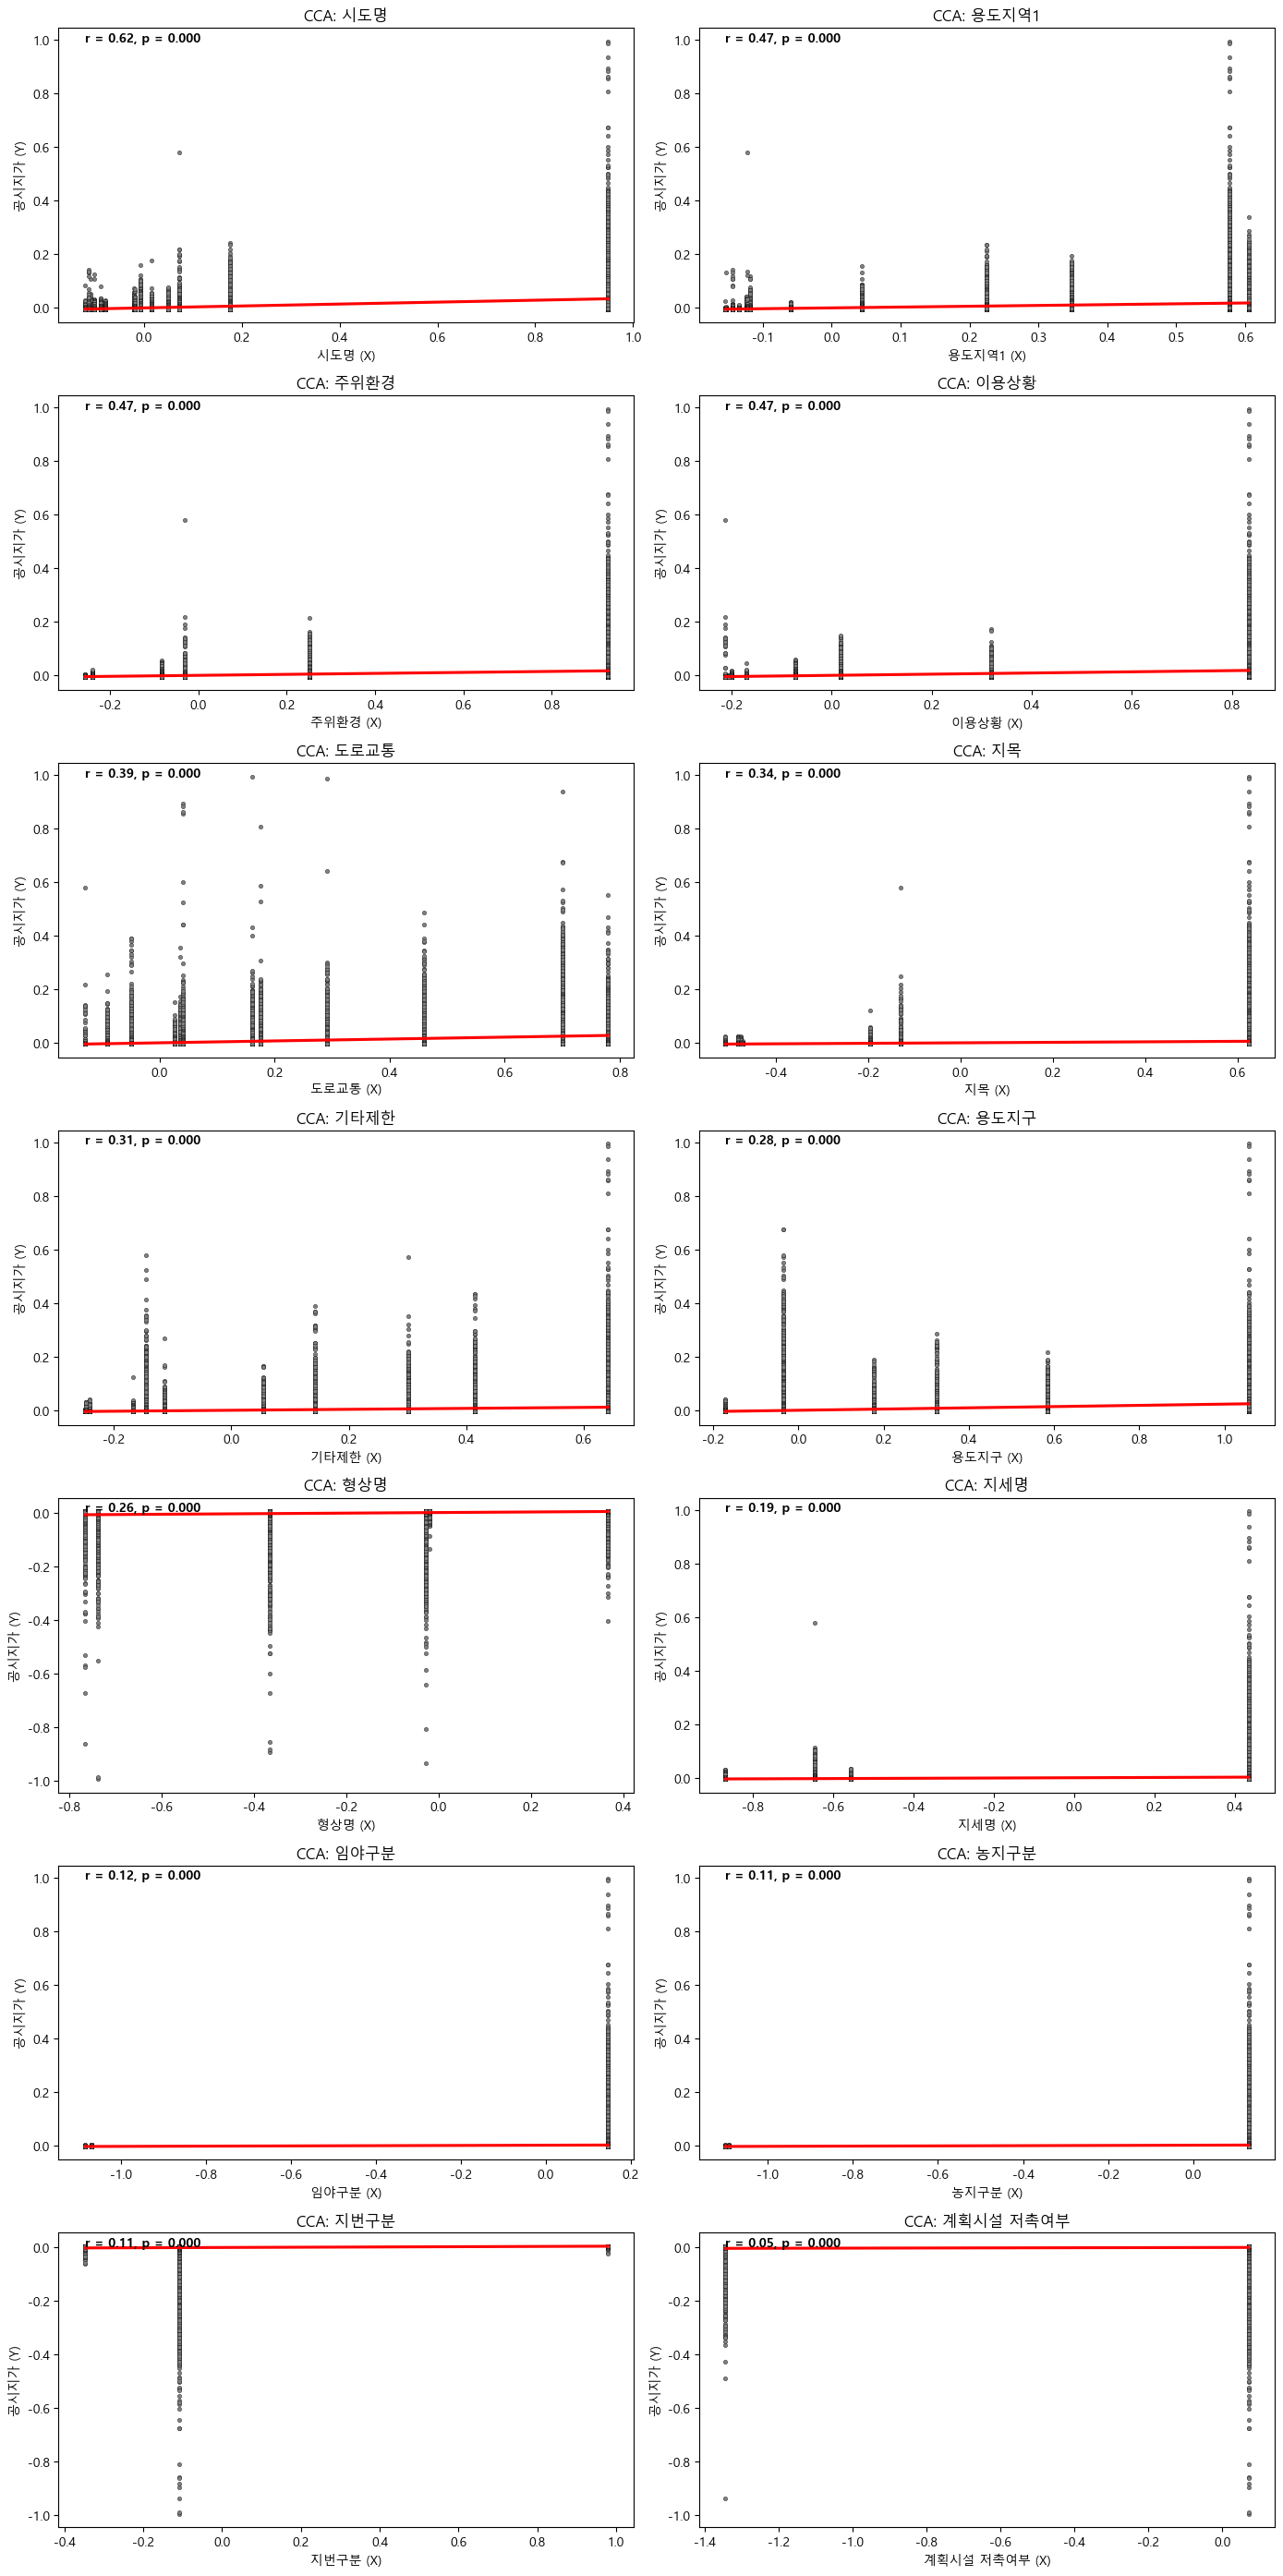

In [ ]:
top_groups = grouped_cca_results.head(14) # 전체 변수 다 시각화 

# 서브플롯 구성
fig, axes = plt.subplots(7, 2, figsize=(14, 28))
axes = axes.flatten()

# 시각화
for i, row in enumerate(top_groups.itertuples()):
    base_var = row._1  # 기존 변수명
    feature_cols = [col for col in df_final.columns if col.startswith(base_var + "_")]

    X = df_final[feature_cols].values
    Y = y_scaled

    cca = CCA(n_components=1, scale=False)
    X_c, Y_c = cca.fit(X, Y).transform(X, Y)

    r = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
    p = linregress(X_c[:, 0], Y_c[:, 0]).pvalue

    ax = axes[i]
    sns.scatterplot(x=X_c[:, 0], y=Y_c[:, 0], color='grey', edgecolor='k', s=10, ax=ax)
    sns.regplot(x=X_c[:, 0], y=Y_c[:, 0], scatter=False, color='red', ax=ax)

    # 주석 텍스트
    ax.text(min(X_c[:, 0]), max(Y_c[:, 0]), f'r = {r:.2f}, p = {p:.3f}',
            horizontalalignment='left', size='medium', color='black', weight='semibold')

    ax.set_xlabel(f'{base_var} (X)')
    ax.set_ylabel('공시지가 (Y)')
    ax.set_title(f'CCA: {base_var}')

plt.tight_layout()
plt.show()

### 2-2. 통계 분석


공시지가의 정규성을 가정할 수 없으므로, Kruskal-Wallis H-test 검정

In [4]:
from scipy.stats import kruskal

kruskal_results = []
excluded_vars = []

# 전체 변수 순회
for col in df.columns:
    if col in ['내년_공시지가', '공시지가_4분위']:
        continue  # 제외할 컬럼

    unique_vals = df[col].nunique()

    if unique_vals <= 2:
        excluded_vars.append(f"{col} (변수의 값이 {unique_vals}개니까 제외)")
        continue # 크루스칼 왈리스 검정은 3개 이상의 값(그룹) 필요

    try:
        groups = [df[df[col] == val]['내년_공시지가'] for val in df[col].dropna().unique()]
        stat, p = kruskal(*groups)
        kruskal_results.append({'변수명': col, 'H 통계량': stat, 'p-value': p})
    except Exception as e:
        excluded_vars.append(f"{col} (오류 발생: {str(e)})")

kruskal_df = pd.DataFrame(kruskal_results).sort_values(by='H 통계량', ascending=False).reset_index(drop=True)

# 결과 출력
print("✅ Kruskal-Wallis 결과")
print(kruskal_df)

print("\n❌ 제외된 변수:")
for msg in excluded_vars:
    print(msg)


✅ Kruskal-Wallis 결과
      변수명          H 통계량  p-value
0    주위환경  325413.400321      0.0
1   용도지역1  310794.571648      0.0
2    이용상황  303430.475159      0.0
3      면적  292040.511392      0.0
4      지목  273228.617553      0.0
5     시도명  215043.366248      0.0
6    도로교통  183308.300423      0.0
7    기타제한  151116.688649      0.0
8     지세명  131612.014712      0.0
9     형상명  130905.909987      0.0
10   임야구분  104709.275122      0.0
11   지번구분   93426.754826      0.0
12   용도지구   43222.230845      0.0
13   농지구분   25782.931703      0.0

❌ 제외된 변수:
계획시설 저촉여부 (변수의 값이 2개니까 제외)


C:\Users\jeongbin\AppData\Local\Temp\ipykernel_14636\4272058645.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=kruskal_top, y='변수명', x='H 통계량', palette='viridis')


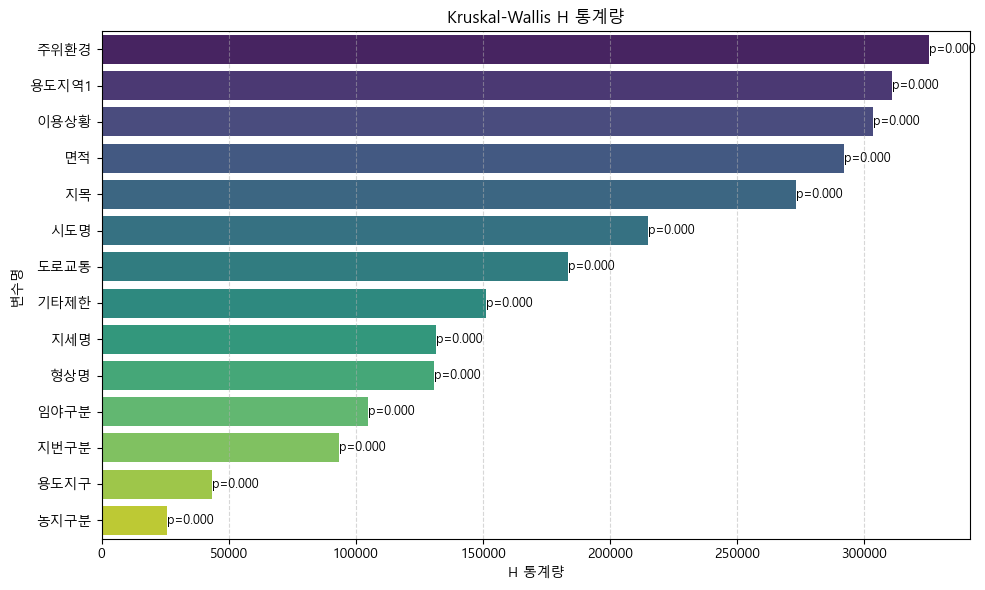

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# H 통계량 기준 정렬
kruskal_df_sorted = kruskal_df.sort_values(by='H 통계량', ascending=False).reset_index(drop=True)

# 상위 15개만 시각화 (필요에 따라 조정 가능)
top_n = 15
kruskal_top = kruskal_df_sorted.head(top_n)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=kruskal_top, y='변수명', x='H 통계량', palette='viridis')

# 각 막대 끝에 p-value 텍스트 추가
for i, row in kruskal_top.iterrows():
    pval_str = f"{row['p-value']:.3f}"
    plt.text(row['H 통계량'] + 0.5, i, f"p={pval_str}", va='center', fontsize=9)

plt.title(f'Kruskal-Wallis H 통계량')
plt.xlabel('H 통계량')
plt.ylabel('변수명')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


* 모든 p-value가 0.0 (즉, 매우 유의미함) → 각 변수 그룹 간에 공시지가가 통계적으로 유의미한 차이가 있음
* 주위환경, 용도지역1, 이용상황 등은 H 값이 높음 → 공시지가에 큰 영향 줄 가능성 높음
* 농지구분, 용도지구는 비교적 낮음 → 영향력이 덜할 수 있음

In [ ]:
from scipy.stats import mannwhitneyu

# 분석 대상 변수
binary_col = '계획시설 저촉여부' # 이진 변수이므로, 만 휘트니 검정 실시

# 두 그룹 나누기
group1 = df[df[binary_col] == df[binary_col].unique()[0]]['내년_공시지가']
group2 = df[df[binary_col] == df[binary_col].unique()[1]]['내년_공시지가']

# Mann-Whitney U Test
stat, p = mannwhitneyu(group1, group2, alternative='two-sided')

print(f"✅ Mann-Whitney U Test 결과 for '{binary_col}'")
print(f"U 통계량 = {stat:.2f}")
print(f"p-value = {p:.4f}")


✅ Mann-Whitney U Test 결과 for '계획시설 저촉여부'
U 통계량 = 6616319698.00
p-value = 0.0000


u통계량은 변수의 값이 많아서 크게 발생. 

계획시설 저촉여부에 따라 공시지가가 통계적으로 유의미하게 다름

### VIF 제거

In [ ]:
# 실험 재현
import pickle
with open("./split_data/split_data_3way.pkl", "rb") as f:
    X_train, X_valid, X_test, y_train, y_valid, y_test = pickle.load(f)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF 계산 
def calculate_vif_from_X_train():
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_train.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    return vif_data.sort_values("VIF", ascending=False)

vif_result = calculate_vif_from_X_train()
high_vif_cols = vif_result[vif_result["VIF"] > 10]["feature"].tolist()



In [ ]:
# 다중 공선성이 10이상이 변수만 출력
high_vif_result = vif_result[vif_result["VIF"] > 10]
for _, row in high_vif_result.iterrows():
    print(f"📌 변수: {row['feature']} | VIF: {row['VIF']:.2f}")


📌 변수: 임야구분_비임야 | VIF: 441.64
📌 변수: 이용상황_자연림 | VIF: 175.31
📌 변수: 주위환경_농촌·경작지대 | VIF: 165.47
📌 변수: 주위환경_산림지대 | VIF: 142.61
📌 변수: 이용상황_단독주택 | VIF: 110.02
📌 변수: 지세명_평지 | VIF: 102.93
📌 변수: 이용상황_전 | VIF: 94.34
📌 변수: 기타제한_기타 | VIF: 90.23
📌 변수: 지목_대 | VIF: 88.10
📌 변수: 이용상황_답 | VIF: 76.87
📌 변수: 농지구분_비농지 | VIF: 76.71
📌 변수: 주위환경_주거지대 | VIF: 66.07
📌 변수: 지목_임야 | VIF: 56.29
📌 변수: 용도지구_미지정 | VIF: 54.98
📌 변수: 지세명_완경사지 | VIF: 54.91
📌 변수: 지목_답 | VIF: 53.59
📌 변수: 도로교통_세로(가) | VIF: 50.48
📌 변수: 지목_전 | VIF: 46.53
📌 변수: 이용상황_상업용 | VIF: 44.28
📌 변수: 주위환경_상업지대 | VIF: 37.32
📌 변수: 이용상황_주상용 | VIF: 27.82
📌 변수: 도로교통_세로(불) | VIF: 27.10
📌 변수: 도로교통_맹지 | VIF: 26.91
📌 변수: 기타제한_교육환경보호구역 | VIF: 22.10
📌 변수: 도로교통_소로한면 | VIF: 16.72
📌 변수: 이용상황_과수원 | VIF: 15.79
📌 변수: 기타제한_지구단위계획구역 | VIF: 14.73
📌 변수: 지세명_급경사지 | VIF: 11.06
📌 변수: 형상명_부정형 | VIF: 10.08


In [9]:
# 변수 제거
X_train = X_train.drop(columns=high_vif_cols)
X_valid = X_valid.drop(columns=high_vif_cols)
X_test = X_test.drop(columns=high_vif_cols)

In [ ]:
# VIF 제거 버전 저장
'''
with open("./split_data/VIF_split_data_3way.pkl", "wb") as f:
    pickle.dump((X_train, X_valid, X_test, y_train, y_valid, y_test), f)
'''